# Initialize the Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
os.environ['MKL_NUM_THREADS'] = '1'
import sys
import glob
import json
import subprocess
from multiprocessing import Pool

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
from Codebase.Networks.SubgraphDetection.nonnegfac import nmf
os.chdir('./Analysis_Notebooks/')

path_MetaData = '/home1/a/ankk/LittHome/Remotes/CORE.ieeg_ltm.multiinst/Raw_Neocortical'
path_CoreData = '/home1/a/ankk/LittHome/Remotes/CORE.ieeg_ltm.multiinst/Dyne_Neocortical/FuncConn.XCorr_WideBand.4_115/network'
path_PeriphData = '/home1/a/ankk/LittHome/Remotes/RSRCH.InterictalSubgraph'
path_InpData = path_PeriphData + '/ds-e01-NMF_Optimization'
path_ExpData = path_PeriphData + '/ds-e02-NMF_Estimation'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

/home1/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Generate Data List

In [4]:
# Get clinical_metadata
df_meta = h5py.File('{}/clinical_metadata.mat'.format(path_MetaData), 'r')
meta_subj = [''.join(unichr(c) for c in df_meta[r])
             for r in df_meta['subject']['ID'][:, 0]]

# Read the Condition Checking Result
ev_list = np.load("{}/NMF_Good_Events.npz".format(path_InpData))['event_list']

subj_dict = {}
good_ev_list = []
bad_ev_list = []
for path, cnd_num in ev_list:
    path = str(path)
    cnd_num = float(cnd_num)
    
    if np.isnan(cnd_num) or (cnd_num > 1e5):
        bad_ev_list.append(path)
        continue
    else:
        good_ev_list.append(path)

    full_id = path.split('/')[-1]
    subj_id = full_id.split('-')[0]
    epoch_id = full_id.split('-')[1]
    block_id = full_id.split('-')[3].split('.')[0]
    
    try:
        subj_dict[subj_id]
    except KeyError:
        subj_dict[subj_id] = {}

    try:
        subj_dict[subj_id][epoch_id]
    except KeyError:
        subj_dict[subj_id][epoch_id] = {}

    # Check that the path exists
    
    
    try:
        subj_dict[subj_id][epoch_id][block_id]
    except KeyError:
        subj_dict[subj_id][epoch_id][block_id] = {}
    
    subj_dict[subj_id][epoch_id][block_id] = \
               {'dyne_output': path,
                'dyne_log': '{}/{}-{}-block-{}.mat.dyne_log.csv'.format(path_CoreData,
                                                                        subj_id, epoch_id, block_id)
               }

# NMF Subgraph Estimation

## Set processing items

In [5]:
alpha = 0.0
beta = 0.0
n_run = 25

proc_item = []
for subj_id in subj_dict.keys():
    opt_rank = int(np.load('{}/{}.Num_Subgraph.npz'.format(path_InpData, subj_id))['n_subgraph'])

    for epoch_id in subj_dict[subj_id].keys():
        for block_id in subj_dict[subj_id][epoch_id].keys():
            param = {'alpha': alpha,
                     'beta': beta,
                     'rank': opt_rank,
                     'n_run': n_run}
            
            proc_dict = {'data_path': subj_dict[subj_id][epoch_id][block_id],
                         'output_name': '{}.{}.{}'.format(subj_id, epoch_id, block_id),
                         'param_set': param}
            proc_item.append(proc_dict)
        
np.savez('{}/NMF_Estimation.Proc_Items.npz'.format(path_ExpData),
         proc_item=proc_item)

## Run NMF on Proc_Item List

In [8]:
parallel_run = True
proc_item = np.load('{}/NMF_Estimation.Proc_Items.npz'.format(path_ExpData))['proc_item']

# Remove already completed items from proc list
new_proc_item = []
for pitem in proc_item:
    if not os.path.exists("{}/{}.npz".format(path_ExpData, pitem['output_name'])):
        new_proc_item.append(pitem)
proc_item = new_proc_item


# Setup helper function to map NMF run
def _start_helper(pitem):
    print('Processing: {}'.format(pitem['output_name']))
    
    # Getting Data from Dyne
    df_log = pd.read_csv(pitem['data_path']['dyne_log'], delimiter=',')
    pipe_hash = np.array(df_log[df_log.PIPE_NAME == 'CrossCorrelation'].DOWNSTREAM_HASH)[0]
    df_outp = h5py.File(pitem['data_path']['dyne_output'], 'r')
    cfg_matr = conv_adj_matr_to_cfg_matr(df_outp[pipe_hash]['data'][...])
    
    # Setup NMF
    cfg_matr = np.nan_to_num(cfg_matr)
    n_win = cfg_matr.shape[0]
    n_conn = cfg_matr.shape[1]
    
    subgraph_estimate = []
    for run_i in xrange(pitem['param_set']['n_run']):
        # Initialize the factors for NMF
        fac_subnet = np.random.uniform(low=0, high=1.0,
                                       size=(pitem['param_set']['rank'],
                                             n_conn))
        fac_coef = np.random.uniform(low=0, high=1.0,
                                     size=(pitem['param_set']['rank'],
                                           n_win))

        # Run NMF Algorithm
        try:
            fac_subnet, fac_coef, err = nmf.snmf_bcd(
                cfg_matr,
                alpha=pitem['param_set']['alpha'],
                beta=pitem['param_set']['beta'],
                fac_subnet_init=fac_subnet,
                fac_coef_init=fac_coef,
                max_iter=100, verbose=False)
        except np.linalg.linalg.LinAlgError as e:
            print(e)
            return 0
        
        subgraph_estimate.append({'fac_subnet': fac_subnet,
                                  'fac_coef': fac_coef,
                                  'err': err})
        
    # Cache the NMF result
    np.savez("{}/{}.npz".format(path_ExpData, pitem['output_name']),
             subgraph_estimate=subgraph_estimate,
             param_set=pitem['param_set'])
    
if parallel_run:
    mp = Pool(30)
    mp.map(_start_helper, proc_item)
else:
    map(_start_helper, proc_item)

Processing: HUP64.interictal.3263


Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Singular matrix


(-1, 6)

/home1/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


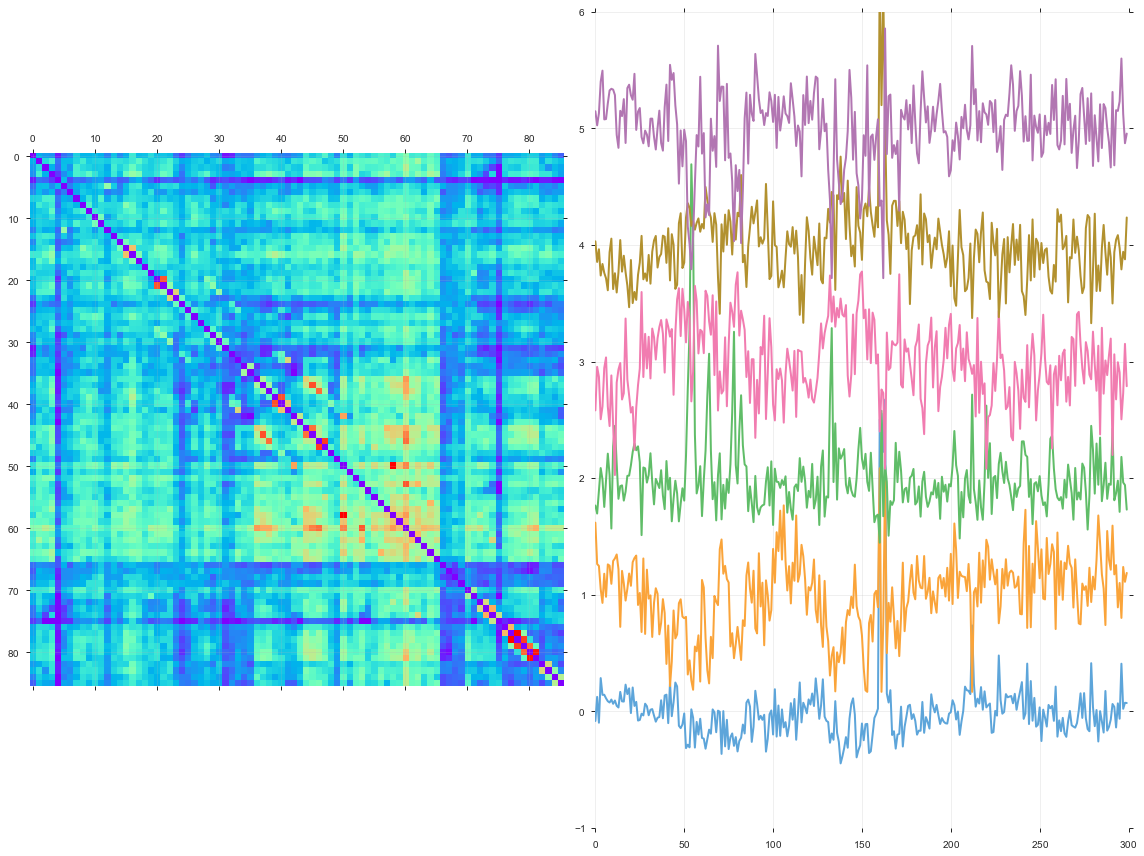

In [10]:
%matplotlib inline

df_out = np.load("{}/{}.npz".format(path_ExpData, 'HUP78.interictal.2184'))['subgraph_estimate']
fac_subnet = df_out[4]['fac_subnet'][5, :]
fac_coef_all = df_out[4]['fac_coef']

plt.figure(figsize=(16,12))
ax = plt.subplot(1,2,1)
ax.matshow(conv_cfg_vec_to_adj_matr(fac_subnet), cmap='rainbow')

ax = plt.subplot(1,2,2)
for ii in xrange(fac_coef_all.shape[0]):
    fac_coef = fac_coef_all[ii, :]
    fac_coef = (fac_coef - fac_coef.mean()) / (3*fac_coef.std())
    ax.plot(np.arange(len(fac_coef)),
            fac_coef+ii)
ax.set_ylim([-1, ii+1])